Epoch     0 | Total Loss: 4.2361e+02 | BC Loss: 8.3722e-02 | Eq Loss: 4.2352e+02
Epoch  1000 | Total Loss: 3.2297e-02 | BC Loss: 2.8196e-02 | Eq Loss: 4.1016e-03
Epoch  2000 | Total Loss: 3.0264e-02 | BC Loss: 2.7189e-02 | Eq Loss: 3.0746e-03
Epoch  3000 | Total Loss: 2.8143e-02 | BC Loss: 2.5988e-02 | Eq Loss: 2.1548e-03
Epoch  4000 | Total Loss: 2.6524e-02 | BC Loss: 2.4879e-02 | Eq Loss: 1.6451e-03
Epoch  5000 | Total Loss: 2.5387e-02 | BC Loss: 2.3920e-02 | Eq Loss: 1.4668e-03
Epoch  6000 | Total Loss: 2.4454e-02 | BC Loss: 2.2996e-02 | Eq Loss: 1.4579e-03
Epoch  7000 | Total Loss: 2.3500e-02 | BC Loss: 2.1969e-02 | Eq Loss: 1.5307e-03
Epoch  8000 | Total Loss: 2.2409e-02 | BC Loss: 2.0727e-02 | Eq Loss: 1.6820e-03
Epoch  9000 | Total Loss: 2.1137e-02 | BC Loss: 1.9182e-02 | Eq Loss: 1.9548e-03
Epoch 10000 | Total Loss: 1.9636e-02 | BC Loss: 1.7271e-02 | Eq Loss: 2.3655e-03
Epoch 11000 | Total Loss: 1.7775e-02 | BC Loss: 1.4943e-02 | Eq Loss: 2.8325e-03
Epoch 12000 | Total Loss: 1.

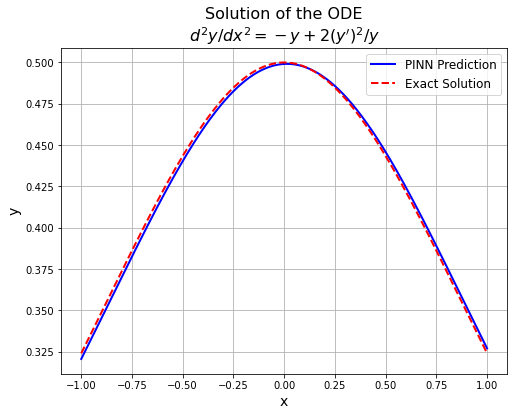

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define Physics-Informed Neural Network (PINN) model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),    # Input layer (1-dimensional x)
            nn.Tanh(),            # Activation function
            nn.Linear(20, 20),    # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer (predicted y value)
        )
    
    def forward(self, x):
        return self.layers(x)

# Define derivative computation function
def compute_derivatives(y, x):
    """Compute first and second derivatives of y with respect to x"""
    dy_dx = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]
    
    d2y_dx2 = torch.autograd.grad(
        outputs=dy_dx,
        inputs=x,
        grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]
    return dy_dx, d2y_dx2

# Training parameters setup
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20000  # Number of training epochs
epsilon = 1e-8   # Small value to prevent division by zero

# Boundary condition data (converted to tensors)
x_bc = torch.tensor([[-1.0], [1.0]], dtype=torch.float32, requires_grad=True)
y_bc_true = torch.tensor([[0.324027137], [0.324027137]], dtype=torch.float32)

# Internal point sampling (training domain)
x_in = torch.linspace(-1, 1, 300).view(-1, 1).requires_grad_(True)

# Training loop
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Boundary condition loss
    y_bc_pred = model(x_bc)
    loss_bc = torch.mean((y_bc_pred - y_bc_true)**2)
    
    # Equation residual loss
    y_in = model(x_in)
    dy_dx, d2y_dx2 = compute_derivatives(y_in, x_in)
    
    # Compute equation residual d2y/dx2 + y - 2*(dy/dx)^2/y = 0
    residual = d2y_dx2 + y_in - 2 * (dy_dx**2) / (y_in + epsilon)
    loss_eq = torch.mean(residual**2)
    
    # Total loss (weighted sum)
    loss = loss_bc + loss_eq
    
    # Backward propagation
    loss.backward()
    optimizer.step()
    
    # Record loss value
    loss_history.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch {epoch:5d} | Total Loss: {loss.item():.4e} | BC Loss: {loss_bc.item():.4e} | Eq Loss: {loss_eq.item():.4e}')

        
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Generate test points
x_test = torch.linspace(-1, 1, 300).view(-1, 1)

# Compute exact solution
def exact_solution(x):
    return 0.5 / np.cosh(x)

x_np = x_test.numpy().flatten()
y_exact = exact_solution(x_np)
# Plot solution curves

with torch.no_grad():
    y_pred = model(x_test).numpy()

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_np, y_pred, 'b-', linewidth=2, label='PINN Prediction')
plt.plot(x_np, y_exact, 'r--', linewidth=2, label='Exact Solution')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(fontsize=12)
plt.title('Solution of the ODE\n$d^2y/dx^2 = -y + 2(y\')^2/y$', fontsize=16)
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9977387245012814, mae_pinn: 0.002417119452729821, rmse_pinn: 0.0026163479778915644, inf_norm_pinn: 0.0036218762397766113


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_15.csv', index=False)
print(" pinn_15.csv")

数据已保存至 pinn_15.csv
